In [87]:
# Basic imports
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load data
df = pd.read_csv('data.csv')
print(df.columns)

# Print number of classes
tot_lab = df.shape[0]
neg_lab = df.loc[df['loan_status']=='Fully Paid'].shape[0]
pos_lab = df.loc[df['loan_status']=='Charged Off'].shape[0]

print('Total #entries: ', tot_lab)
print('Negative class fraction: ', neg_lab*100/tot_lab)
print('Positive class fraction: ', pos_lab*100/tot_lab)
assert(tot_lab == neg_lab + pos_lab)

Index(['term', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'earliest_cr_line', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'application_type', 'mort_acc',
       'pub_rec_bankruptcies'],
      dtype='object')
Total #entries:  1345310
Negative class fraction:  80.03738915194268
Positive class fraction:  19.962610848057324


* This is a binary classification problem with class imbalance

In [88]:
df.head(5)

,term,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,zip_code,addr_state,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies
0,36 months,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,debt_consolidation,Debt consolidation,190xx,PA,5.91,Aug-2003,7.0,0.0,2765.0,29.7,13.0,w,Individual,1.0,0.0
1,36 months,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,small_business,Business,577xx,SD,16.06,Dec-1999,22.0,0.0,21470.0,19.2,38.0,w,Individual,4.0,0.0
2,60 months,truck driver,10+ years,MORTGAGE,63000.0,Not Verified,Dec-2015,Fully Paid,home_improvement,NaN,605xx,IL,10.78,Aug-2000,6.0,0.0,7869.0,56.2,18.0,w,Joint App,5.0,0.0
3,60 months,Contract Specialist,3 years,MORTGAGE,104433.0,Source Verified,Dec-2015,Fully Paid,major_purchase,Major purchase,174xx,PA,25.37,Jun-1998,12.0,0.0,21929.0,64.5,35.0,w,Individual,6.0,0.0
4,36 months,Veterinary Tecnician,4 years,RENT,34000.0,Source Verified,Dec-2015,Fully Paid,debt_consolidation,Debt consolidation,300xx,GA,10.20,Oct-1987,5.0,0.0,8822.0,68.4,6.0,w,Individual,0.0,0.0


In [89]:
# Be sure that all the data is labeled (no missing values for labels)
print(df['loan_status'].unique())

['Fully Paid' 'Charged Off']


## Exploratory data analysis

### Define some plotting functions

In [90]:
def plot_bar (colname, df, set_xrange=False, xrange=(0,0), figsize=(9,3), sort=False, rotate=False):
    
    # Split the data in positive and negative classes 
    df_pos = df.loc[df['loan_status']=='Fully Paid']
    df_neg = df.loc[df['loan_status']=='Charged Off']

    # Get features associated with the positive class
    pos_feature = df_pos[colname].value_counts()
    norm_pos_feature = {d:pos_feature[d]/sum(pos_feature.values) for d in dict(pos_feature)}

    # Get features associated with the negative class
    neg_feature = df_neg[colname].value_counts()
    norm_neg_feature = {d:neg_feature[d]/sum(neg_feature.values) for d in dict(neg_feature)}
    
    if sort:
        from datetime import datetime
        from dateutil import parser
        
        date_list = ['{}-{}'.format(parser.parse(dt).month, parser.parse(dt).year) for dt in 
                     list(norm_pos_feature.keys())]
        tmp = [datetime.strptime(dt, "%m-%Y") for dt in date_list]
        sort_indices = sorted(range(len(tmp)), key=lambda k: tmp[k])
        pos_keys = np.asarray(list(norm_pos_feature.keys()))[sort_indices]
        pos_values = np.asarray(list(norm_pos_feature.values()))[sort_indices]
        
        date_list = ['{}-{}'.format(parser.parse(dt).month, parser.parse(dt).year) for dt in 
                     list(norm_neg_feature.keys())]
        tmp = [datetime.strptime(dt, "%m-%Y") for dt in date_list]
        sort_indices = sorted(range(len(tmp)), key=lambda k: tmp[k])
        neg_keys = np.asarray(list(norm_neg_feature.keys()))[sort_indices]
        neg_values = np.asarray(list(norm_neg_feature.values()))[sort_indices]
    else:
        pos_keys = norm_pos_feature.keys()
        pos_values = norm_pos_feature.values()
        neg_keys = norm_neg_feature.keys()
        neg_values = norm_neg_feature.values()
    
    # Plot probability density distributions for both classes
    fig, axs = plt.subplots(1,1, figsize=figsize)
    axs.bar(pos_keys, pos_values, alpha=0.5, label='Paid')
    axs.bar(neg_keys, neg_values, alpha=0.5, label='Not paid')
    axs.legend()
    if set_xrange:
        axs.set_xlim(xrange[0],xrange[1])
    if rotate:
        plt.xticks(rotation=90)
    plt.title('{} p.d.f'.format(colname))

In [91]:
def plot_hist (colname, df, xrange, nbins, xlabel, figsize=(9,3)):
    
    # Split the data in positive and negative classes 
    df_pos = df.loc[df['loan_status']=='Fully Paid']
    df_neg = df.loc[df['loan_status']=='Charged Off']
    
    # Plot probability density distributions for both classes
    fig, axs = plt.subplots(1,1, figsize=(9,3))
    axs.hist(df_pos[colname].values, bins=nbins, range=xrange, density=True, alpha=0.5, label='Paid')
    axs.hist(df_neg[colname].values, bins=nbins, range=xrange, density=True, alpha=0.5, label='Not paid')
    axs.legend()
    plt.title('{} p.d.f'.format(colname))
    plt.xlabel(xlabel)

## Probability distribution functions for each variable

### term

In [94]:
print('before pre-processing: ', df['term'].unique())

# Remove artificial space from this feature
dfmod = df.copy()
dfmod['term'] = df['term'].apply(lambda x: x if str(x)[0] != ' ' else x[1:])
print('after pre-processing: ', dfmod['term'].unique())

before pre-processing:  [' 36 months' ' 60 months' '36 months' '60 months']
after pre-processing:  ['36 months' '60 months']


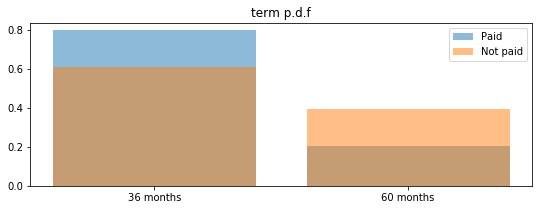

In [95]:
plot_bar('term', dfmod.copy())

### Employment lenght

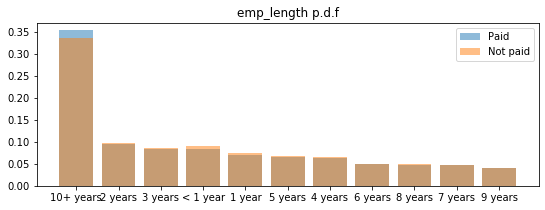

In [96]:
plot_bar('emp_length', df.copy())

* 10+ years of full employment is correlated with loan payment
* < 1 years or 1 years of full employment is correlated with loan debt

In [97]:
print(df['emp_length'].unique())

['10+ years' '3 years' '4 years' '6 years' '7 years' '8 years' '2 years'
 '5 years' '9 years' '< 1 year' '1 year' nan]


In [98]:
# Compute percentage of NaNs
print('Percentage of NaNs for emp_length: {} %'.format(df['emp_length'].isnull().values.sum()*100/df.shape[0]))

Percentage of NaNs for emp_length: 5.8359039923883715 %


### Home ownership

In [99]:
print(df['home_ownership'].unique())

['MORTGAGE' 'RENT' 'OWN' 'ANY' 'NONE' 'OTHER']


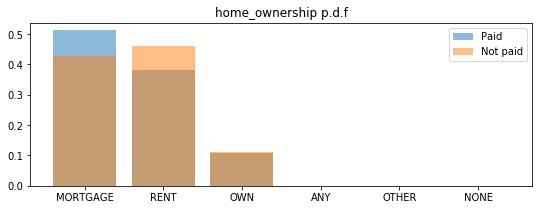

In [100]:
plot_bar('home_ownership', df.copy())

* Mortgage (rent) is correlated with loan payment (debt). Probably also 'Home ownership' is correlated with 'Employment lenght'. A $\chi^{2}$-test on these categorical variables could be performed to verify this hypothesis.

### Annual income

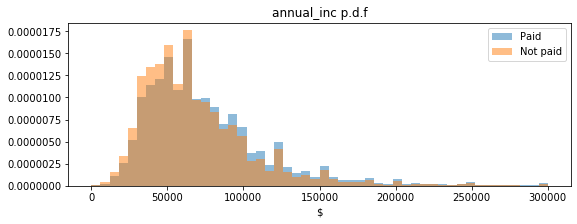

In [101]:
plot_hist ('annual_inc', df.copy(), (0,0.3e6), 50, '\$')

* As expected, higher income is correlated with higher chances for loan payment

### Verification status

In [102]:
print(df['verification_status'].unique())

['Not Verified' 'Source Verified' 'Verified']


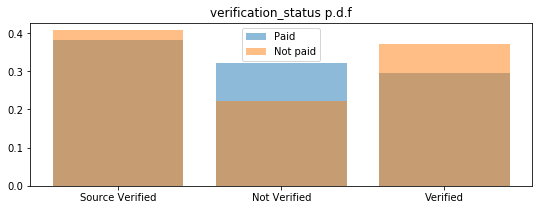

In [103]:
plot_bar('verification_status', df.copy())

### Purpose

In [104]:
print(df['purpose'].unique())

['debt_consolidation' 'small_business' 'home_improvement' 'major_purchase'
 'credit_card' 'other' 'house' 'vacation' 'car' 'medical' 'moving'
 'renewable_energy' 'wedding' 'educational']


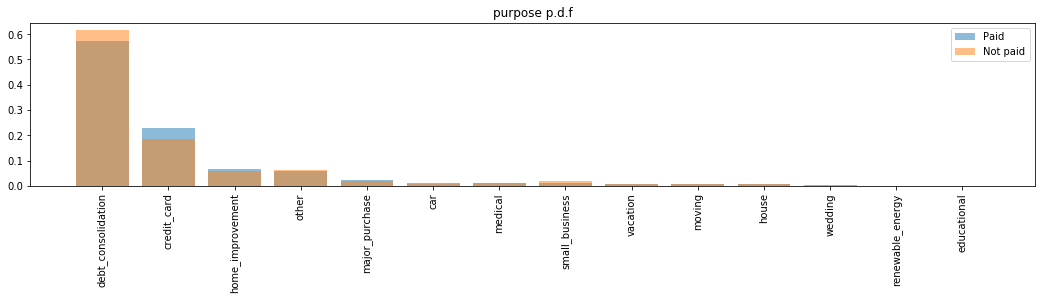

In [106]:
plot_bar('purpose', df.copy(), figsize=(18,3), rotate=True)

* This is informative feature for debt_consolidation and credit_card cases

### zip code

Percentage of NaNs for emp_length: 7.433231002519865e-05 %
['1' '5' '6' '3' '2' '0' '9' '8' '4' '7']


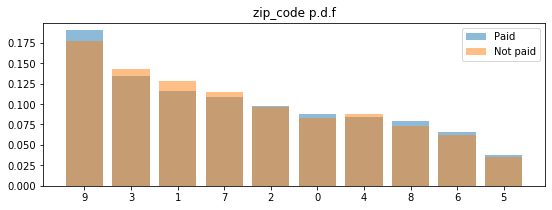

In [107]:
# Get 1st digit from zip_code

print('Percentage of NaNs for emp_length: {} %'.format(df['zip_code'].isnull().values.sum()*100/df.shape[0]))
# Remove NaNs
df = df[df['zip_code'].notna()]

# Get 1st digit from zip_code
dfmod = df.copy()
dfmod['zip_code'] = df['zip_code'].apply(lambda x: str(x)[0:1])

print(dfmod['zip_code'].unique())

plot_bar('zip_code', dfmod.copy())

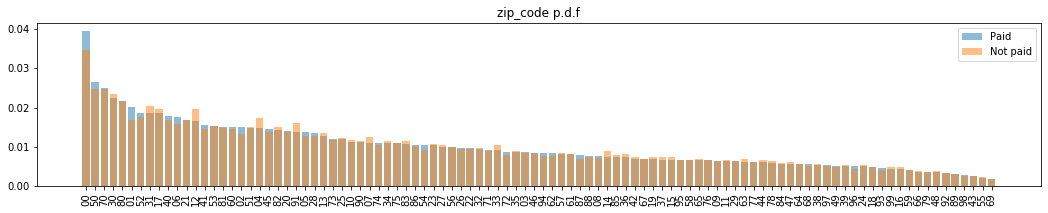

In [109]:
# Get 2nd and 3er digits from zip_code
dfmod = df.copy()
dfmod['zip_code'] = df['zip_code'].apply(lambda x: str(x)[1:3])

plot_bar('zip_code', dfmod.copy(), figsize=(18,3), rotate=True)

* According to https://en.wikipedia.org/wiki/ZIP_Code:
ZIP Codes are numbered with the first digit representing a certain group of U.S. states, the second and third digits together representing a region in that group (or perhaps a large city)

### Address state

In [111]:
print(df['addr_state'].unique())

['PA' 'SD' 'IL' 'GA' 'MN' 'SC' 'RI' 'NC' 'CA' 'VA' 'AZ' 'IN' 'MD' 'NY'
 'TX' 'KS' 'NM' 'AL' 'WA' 'OH' 'LA' 'FL' 'CO' 'MI' 'MO' 'DC' 'MA' 'WI'
 'HI' 'VT' 'NJ' 'DE' 'TN' 'NH' 'NE' 'OR' 'CT' 'AR' 'NV' 'WV' 'MT' 'WY'
 'OK' 'KY' 'MS' 'UT' 'ND' 'ME' 'AK' 'ID' 'IA']


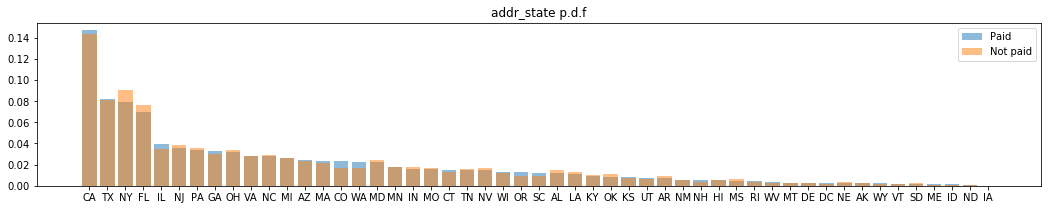

In [112]:
plot_bar('addr_state', df.copy(), figsize=(18,3))

### dti

/Users/marceca/Ixpandit_project/envs/lib/python3.7/site-packages/numpy/lib/histograms.py:834: RuntimeWarning: invalid value encountered in greater_equal
  tmp_w = weights[i:i + BLOCK]
/Users/marceca/Ixpandit_project/envs/lib/python3.7/site-packages/numpy/lib/histograms.py:835: RuntimeWarning: invalid value encountered in less_equal
  


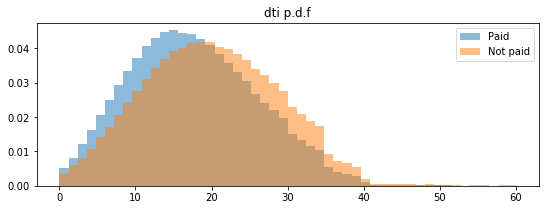

In [113]:
plot_hist ('dti', df.copy(), (0,60), 50, '')

### open_acc

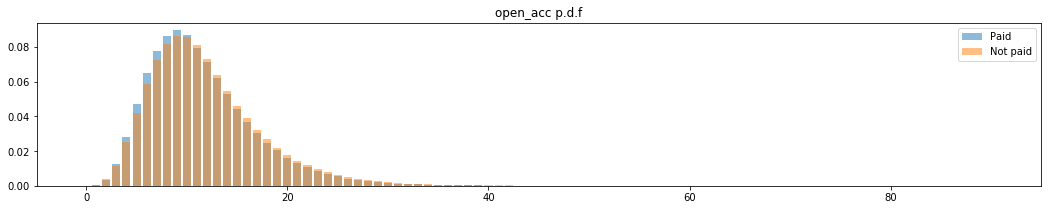

In [114]:
plot_bar('open_acc', df.copy(), figsize=(18,3))

### pub_rec

In [115]:
print(df['pub_rec'].unique())

[ 0.  1.  2.  3.  5.  4. 11.  7.  6.  9. 10. 23.  8. 12. 15. 17. 13. 28.
 20. 86. 18. 21. 14. 16. 19. 49. 22. 47. 46. 37. 40. 63. 34. 54. 24. 25.
 61.]


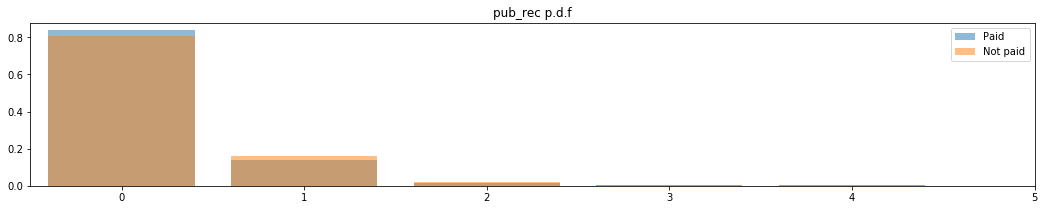

In [116]:
plot_bar('pub_rec', df.copy(), set_xrange=True, xrange=(-0.5,5), figsize=(18,3))

### revolving bal

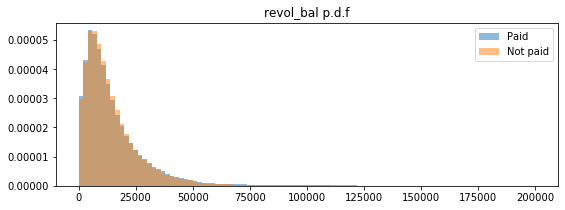

In [117]:
plot_hist ('revol_bal', df.copy(), (0,200000), 100, '')

### revol util

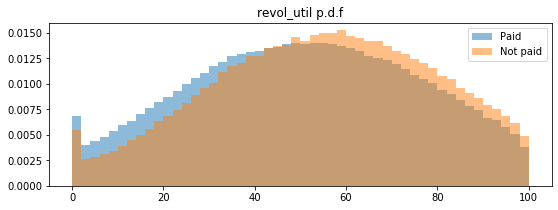

In [118]:
plot_hist ('revol_util', df.copy(), (0,100), 50, '')

### total_acc

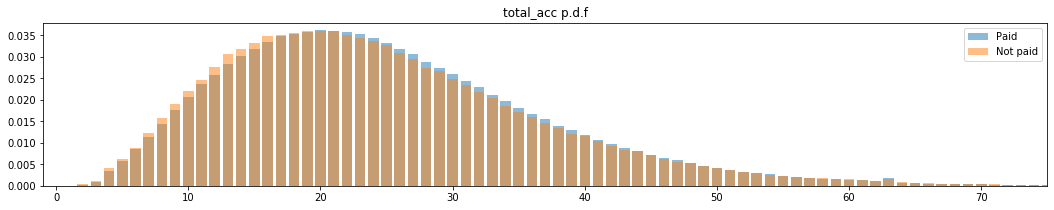

In [119]:
plot_bar('total_acc', df.copy(), set_xrange=True, xrange=(-1,75), figsize=(18,3))

### initial list status

['w' 'f']


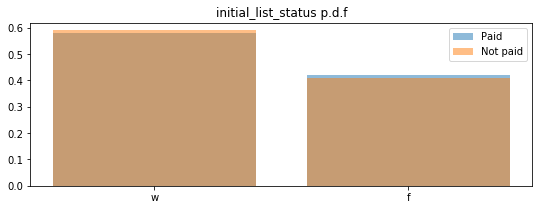

In [120]:
print(df['initial_list_status'].unique())
plot_bar('initial_list_status', df.copy())

### Application type

['Individual' 'Joint App']


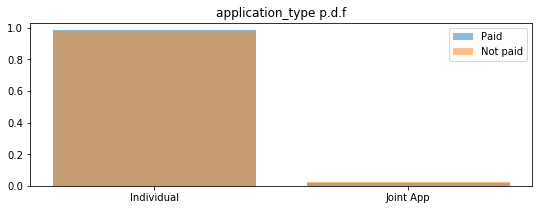

In [121]:
print(df['application_type'].unique())
plot_bar('application_type', df.copy())

### mortgage acc

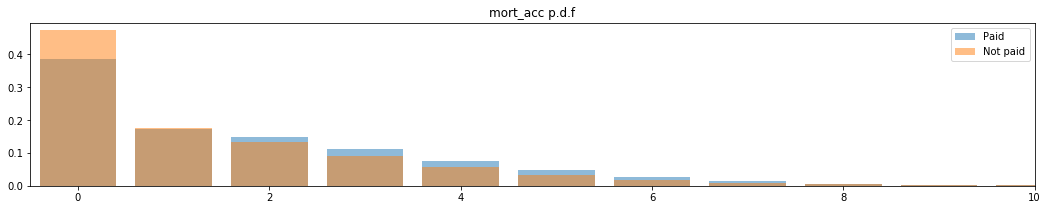

In [122]:
plot_bar('mort_acc', df.copy(), set_xrange=True, xrange=(-0.5,10), figsize=(18,3))

### pub_rec_bankruptcies

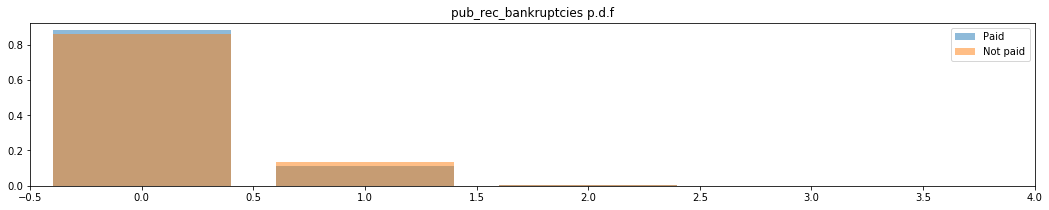

In [123]:
plot_bar('pub_rec_bankruptcies', df.copy(), set_xrange=True, xrange=(-0.5,4), figsize=(18,3))

### issue_d

In [124]:
print(df['issue_d'].unique())

['Dec-2015' 'Nov-2015' 'Oct-2015' 'Sep-2015' 'Aug-2015' 'Jul-2015'
 'Jun-2015' 'May-2015' 'Apr-2015' 'Mar-2015' 'Feb-2015' 'Jan-2015'
 'Mar-2018' 'Feb-2018' 'Jan-2018' 'Sep-2017' 'Aug-2017' 'Jul-2017'
 'Jun-2016' 'May-2016' 'Apr-2016' 'Sep-2018' 'Aug-2018' 'Jul-2018'
 'Jun-2017' 'May-2017' 'Apr-2017' 'Mar-2016' 'Feb-2016' 'Jan-2016'
 'Dec-2014' 'Nov-2014' 'Oct-2014' 'Sep-2014' 'Aug-2014' 'Jul-2014'
 'Jun-2014' 'May-2014' 'Apr-2014' 'Mar-2014' 'Feb-2014' 'Jan-2014'
 'Dec-2018' 'Nov-2018' 'Oct-2018' 'Jun-2018' 'May-2018' 'Apr-2018'
 'Dec-2011' 'Nov-2011' 'Oct-2011' 'Sep-2011' 'Aug-2011' 'Jul-2011'
 'Jun-2011' 'May-2011' 'Apr-2011' 'Mar-2011' 'Feb-2011' 'Jan-2011'
 'Dec-2010' 'Nov-2010' 'Oct-2010' 'Sep-2010' 'Aug-2010' 'Jul-2010'
 'Jun-2010' 'May-2010' 'Apr-2010' 'Mar-2010' 'Feb-2010' 'Jan-2010'
 'Dec-2009' 'Nov-2009' 'Oct-2009' 'Sep-2009' 'Aug-2009' 'Jul-2009'
 'Jun-2009' 'May-2009' 'Apr-2009' 'Mar-2009' 'Feb-2009' 'Jan-2009'
 'Dec-2008' 'Nov-2008' 'Oct-2008' 'Sep-2008' 'Aug-2008' 'Jul-2

In [125]:
# Get month (cyclic feature) and year (monotonic feature) from issue_d
df['issue_month'] = df['issue_d'].apply(lambda x: str(x).split('-')[0])
df['issue_year'] = df['issue_d'].apply(lambda x: str(x).split('-')[1])
df.head(5)

,term,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,zip_code,addr_state,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,issue_month,issue_year
0,36 months,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,debt_consolidation,Debt consolidation,190xx,PA,5.91,Aug-2003,7.0,0.0,2765.0,29.7,13.0,w,Individual,1.0,0.0,Dec,2015
1,36 months,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,small_business,Business,577xx,SD,16.06,Dec-1999,22.0,0.0,21470.0,19.2,38.0,w,Individual,4.0,0.0,Dec,2015
2,60 months,truck driver,10+ years,MORTGAGE,63000.0,Not Verified,Dec-2015,Fully Paid,home_improvement,NaN,605xx,IL,10.78,Aug-2000,6.0,0.0,7869.0,56.2,18.0,w,Joint App,5.0,0.0,Dec,2015
3,60 months,Contract Specialist,3 years,MORTGAGE,104433.0,Source Verified,Dec-2015,Fully Paid,major_purchase,Major purchase,174xx,PA,25.37,Jun-1998,12.0,0.0,21929.0,64.5,35.0,w,Individual,6.0,0.0,Dec,2015
4,36 months,Veterinary Tecnician,4 years,RENT,34000.0,Source Verified,Dec-2015,Fully Paid,debt_consolidation,Debt consolidation,300xx,GA,10.20,Oct-1987,5.0,0.0,8822.0,68.4,6.0,w,Individual,0.0,0.0,Dec,2015


In [126]:
print(df['issue_month'].unique())
print(df['issue_year'].unique())

['Dec' 'Nov' 'Oct' 'Sep' 'Aug' 'Jul' 'Jun' 'May' 'Apr' 'Mar' 'Feb' 'Jan']
['2015' '2018' '2017' '2016' '2014' '2011' '2010' '2009' '2008' '2007'
 '2013' '2012']


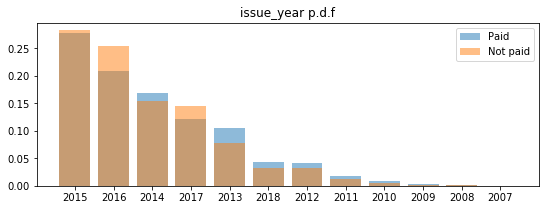

In [127]:
plot_bar('issue_year', df.copy())

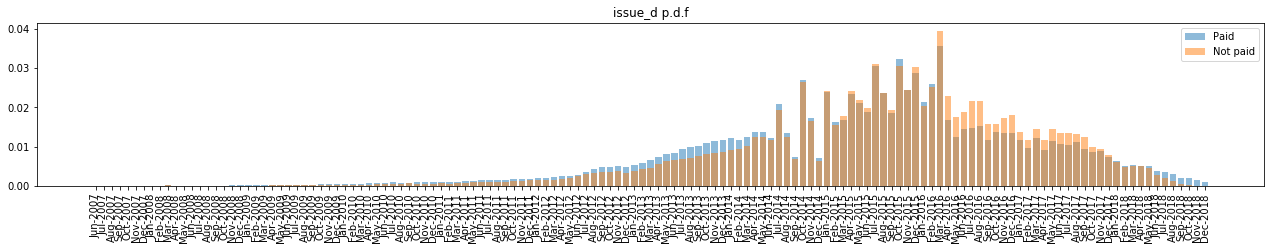

In [128]:
plot_bar('issue_d', df.copy(), figsize=(22,3), sort=True, rotate=True)

* Clear year trend appear. However I don't see seasonal (monthly) trends. I will just use the year information

### earliest_cr_line

In [130]:
# Get year from earliest_cr_line
df['earliest_cr_year'] = df['earliest_cr_line'].apply(lambda x: str(x).split('-')[1])

In [132]:
print(df['earliest_cr_year'].unique())
print('min year: ', min([int(x) for x in df['earliest_cr_year'].unique()]))

['2003' '1999' '2000' '1998' '1987' '1990' '2002' '1994' '1996' '2005'
 '1984' '2001' '1993' '2004' '1991' '2011' '1985' '2007' '1992' '2006'
 '2009' '1997' '1995' '1986' '2012' '2008' '1957' '1974' '2010' '1983'
 '1989' '1981' '1977' '1979' '1988' '1980' '1982' '1973' '1968' '1978'
 '1976' '1975' '1972' '1969' '1965' '1970' '1964' '1966' '1971' '1962'
 '1960' '1967' '1963' '1961' '1959' '1958' '1950' '1956' '1955' '1953'
 '1951' '1952' '1954' '1944' '2014' '2015' '2013' '1934' '1945' '1948'
 '1946' '1949']
min year:  1934


In [133]:
# Convert earliest_cr_year to ordinal values
def convert_earliest_cr_year (row):
    return row['earliest_cr_year'] - 1934

df['earliest_cr_year'] = df['earliest_cr_line'].apply(lambda x: int(str(x).split('-')[1]))
df['earliest_cr_year_mod'] = df.apply (lambda row: convert_earliest_cr_year(row), axis=1)

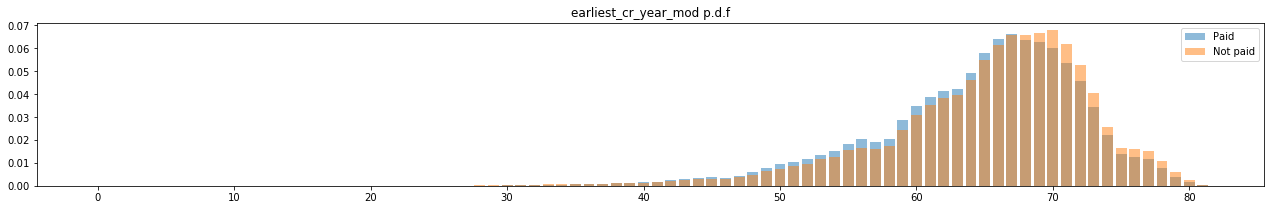

In [134]:
plot_bar('earliest_cr_year_mod', df.copy(), figsize=(22,3))

* Clear year trends can be elucidated.

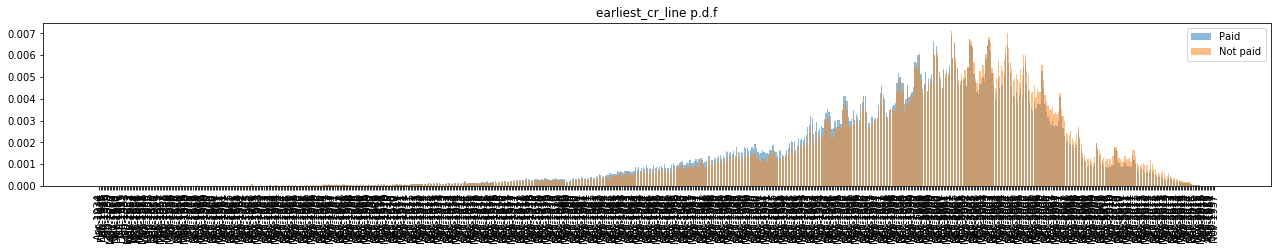

In [136]:
plot_bar('earliest_cr_line', df.copy(), figsize=(22,3), sort=True, rotate=True)

* Doesn't look to add more information than just using the year (above)